## Data Import

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1uLEk-tiSxvMw8DMIQxGuKrEAcAOdH0jx' # Paste the shareable link here

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv') # file will be stored as train.csv in the colab directory

1uLEk-tiSxvMw8DMIQxGuKrEAcAOdH0jx


In [0]:
link = 'https://drive.google.com/open?id=1TiUvc3bkFPj6MhITrfNBfA31kRYOeQBO' # Paste the shareable link here

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')

1TiUvc3bkFPj6MhITrfNBfA31kRYOeQBO


In [0]:
import os
os.listdir('/content/')

['.config', 'adc.json', 'train.csv', 'test.csv', 'sample_data']

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
train.shape, test.shape

((307511, 122), (48744, 121))

## Exploratory Data Analysis and Data Cleaning

In [0]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Imbalanced Class Data - About 8% of the train set are observations that defaulted on their loans
train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [0]:
# data types
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [0]:
# A lot of variables seem to have >50% null values, we will drop the columns with more than 50% null records
train.isnull().sum().sort_values(ascending = False)

COMMONAREA_MEDI                214865
COMMONAREA_AVG                 214865
COMMONAREA_MODE                214865
NONLIVINGAPARTMENTS_MODE       213514
NONLIVINGAPARTMENTS_MEDI       213514
                                ...  
REG_CITY_NOT_LIVE_CITY              0
LIVE_REGION_NOT_WORK_REGION         0
REG_REGION_NOT_WORK_REGION          0
HOUR_APPR_PROCESS_START             0
SK_ID_CURR                          0
Length: 122, dtype: int64

In [0]:
# 17 variables dropped
test.drop(columns = train.columns[train.isnull().sum() > 150000], inplace = True)
train.drop(columns = train.columns[train.isnull().sum() > 150000], inplace = True)
train.shape, test.shape

((307511, 75), (48744, 74))

Let's try to see the patterns in missing fields

In [0]:
# Checking the days_employed predictor
train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [0]:
# 307511 days is more than 1000 years, replacing it with nulls
train['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True)
test['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True)

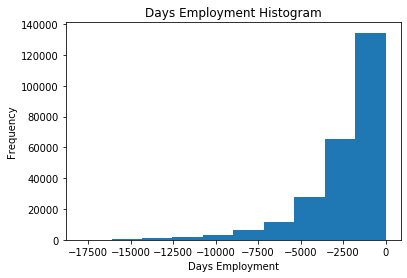

In [0]:
#Checking the distribution of days of employment
train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [0]:
# data is skewed, replacing the nulls with the median
test['DAYS_EMPLOYED']=test['DAYS_EMPLOYED'].fillna(train['DAYS_EMPLOYED'].median())
train['DAYS_EMPLOYED']=train['DAYS_EMPLOYED'].fillna(train['DAYS_EMPLOYED'].median())

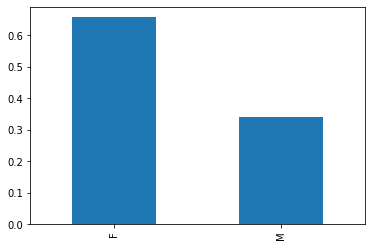

In [0]:
# Checking impact of gender on target variable
((train[train['CODE_GENDER']!='XNA']['CODE_GENDER'].value_counts())/len(train)).plot(kind='bar')

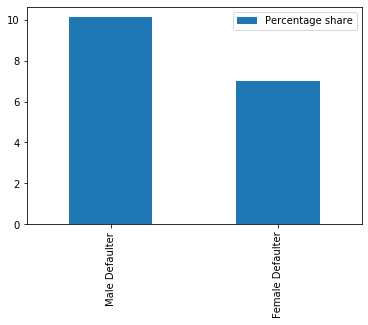

In [0]:
# Male tends to default more
lst=[]

lst.append(len(train[(train['CODE_GENDER']=='M') & (train['TARGET']==1)])*1.0/(len(train[train['CODE_GENDER']=='M'])))
lst.append(len(train[(train['CODE_GENDER']=='F') & (train['TARGET']==1)])*1.0/(len(train[train['CODE_GENDER']=='F'])))

names=['Male Defaulter','Female Defaulter']

gender_default=pd.DataFrame(lst,names)
gender_default=gender_default*100
gender_default.columns=['Percentage share']
gender_default.plot(kind='bar')

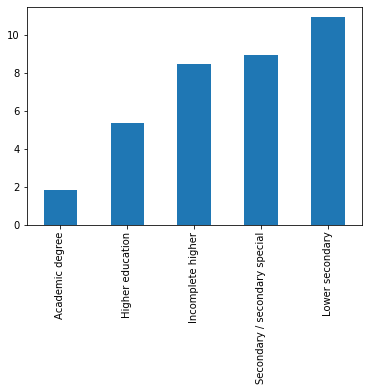

In [0]:
# Checking the impact of education level on target variable - education seems to be inversely proportional to loan default

((train[train['TARGET']==1]['NAME_EDUCATION_TYPE'].value_counts())*100/(train['NAME_EDUCATION_TYPE'].value_counts())).sort_values().plot(kind='bar')

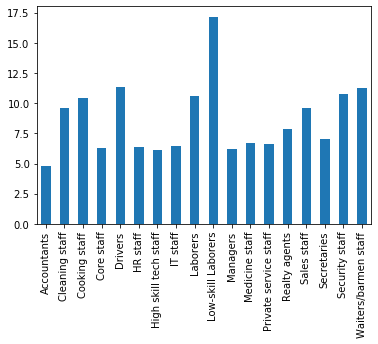

In [0]:
# Low skilled employees tend to do more default

((train[train['TARGET']==1]['OCCUPATION_TYPE'].value_counts())*100/(train['OCCUPATION_TYPE'].value_counts())).plot(kind='bar')

In [0]:
train.AMT_REQ_CREDIT_BUREAU_HOUR.value_counts()

0.0    264366
1.0      1560
2.0        56
3.0         9
4.0         1
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: int64

In [0]:
train.AMT_REQ_CREDIT_BUREAU_DAY.value_counts()

0.0    264503
1.0      1292
2.0       106
3.0        45
4.0        26
5.0         9
6.0         8
9.0         2
8.0         1
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: int64

In [0]:
train.AMT_REQ_CREDIT_BUREAU_MON.value_counts()

0.0     222233
1.0      33147
2.0       5386
3.0       1991
4.0       1076
5.0        602
6.0        343
7.0        298
9.0        206
8.0        185
10.0       132
11.0       119
12.0        77
13.0        72
14.0        40
15.0        35
16.0        23
17.0        14
18.0         6
19.0         3
24.0         1
27.0         1
22.0         1
23.0         1
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: int64

In [0]:
train.AMT_REQ_CREDIT_BUREAU_WEEK.value_counts()

0.0    257456
1.0      8208
2.0       199
3.0        58
4.0        34
6.0        20
5.0        10
8.0         5
7.0         2
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: int64

In [0]:
train.AMT_REQ_CREDIT_BUREAU_QRT.value_counts()

0.0      215417
1.0       33862
2.0       14412
3.0        1717
4.0         476
5.0          64
6.0          28
7.0           7
8.0           7
19.0          1
261.0         1
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: int64

In [0]:
train.AMT_REQ_CREDIT_BUREAU_YEAR.value_counts()[:5]

0.0    71801
1.0    63405
2.0    50192
3.0    33628
4.0    20714
5.0    12052
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: int64

In [0]:
# Except the year, 0 looks the most common value in all other Credit Bureau enquiry fields
train.AMT_REQ_CREDIT_BUREAU_HOUR.fillna(0, inplace=True)
train.AMT_REQ_CREDIT_BUREAU_DAY.fillna(0, inplace=True)
train.AMT_REQ_CREDIT_BUREAU_MON.fillna(0, inplace=True)
train.AMT_REQ_CREDIT_BUREAU_WEEK.fillna(0, inplace=True)
train.AMT_REQ_CREDIT_BUREAU_QRT.fillna(0, inplace=True)

test.AMT_REQ_CREDIT_BUREAU_HOUR.fillna(0, inplace=True)
test.AMT_REQ_CREDIT_BUREAU_DAY.fillna(0, inplace=True)
test.AMT_REQ_CREDIT_BUREAU_MON.fillna(0, inplace=True)
test.AMT_REQ_CREDIT_BUREAU_WEEK.fillna(0, inplace=True)
test.AMT_REQ_CREDIT_BUREAU_QRT.fillna(0, inplace=True)

In [0]:
# Let's explore EXT_SOURCE_3 
train['EXT_SOURCE_3'].value_counts().head(15)

0.746300    1460
0.713631    1315
0.694093    1276
0.670652    1191
0.652897    1154
0.581484    1141
0.689479    1138
0.595456    1136
0.554947    1132
0.621226    1109
0.657784    1092
0.607557    1067
0.643026    1066
0.450747    1064
0.626304    1054
Name: EXT_SOURCE_3, dtype: int64

In [0]:
train['EXT_SOURCE_3'].describe()

count    246546.000000
mean          0.510853
std           0.194844
min           0.000527
25%           0.370650
50%           0.535276
75%           0.669057
max           0.896010
Name: EXT_SOURCE_3, dtype: float64

In [0]:
train.EXT_SOURCE_3.corr(train.EXT_SOURCE_2)

0.10916729237112612

In [0]:
# couldn't find any specific pattern, replacing with median
test.EXT_SOURCE_3.fillna(train.EXT_SOURCE_3.median(),inplace = True)
train.EXT_SOURCE_3.fillna(train.EXT_SOURCE_3.median(),inplace = True)

In [0]:
# Occupation Type
train.OCCUPATION_TYPE.value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [0]:
# checking if salary is related with OCCUPATION_TYPE - all the salaries are very close, can't get any inference out of it
train.groupby(train.OCCUPATION_TYPE).describe()['AMT_INCOME_TOTAL']

,count,mean,std,min,25%,50%,75%,max
OCCUPATION_TYPE,,,,,,,,
Accountants,9813.0,194578.357842,108876.812807,27000.0,130500.0,178650.0,225000.0,2214117.0
Cleaning staff,4653.0,130790.895551,64075.793833,25650.0,90000.0,112500.0,157500.0,1080000.0
Cooking staff,5946.0,138396.508176,62742.083077,27000.0,90000.0,126000.0,171000.0,540000.0
Core staff,27570.0,172656.695254,98147.105697,27000.0,112500.0,157500.0,202500.0,3600000.0
Drivers,18603.0,187011.606413,82593.382899,27000.0,135000.0,180000.0,225000.0,2475000.0
HR staff,563.0,188916.282416,93155.321259,30600.0,135000.0,158400.0,225000.0,699750.0
High skill tech staff,11380.0,182842.045683,95711.001374,27000.0,112500.0,157500.0,225000.0,1890000.0
IT staff,526.0,213465.601711,142009.791936,45000.0,135000.0,180000.0,247500.0,2025000.0
Laborers,55186.0,166357.482525,504164.664318,27000.0,112500.0,157500.0,202500.0,117000000.0


In [0]:
train['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [0]:
train.NAME_TYPE_SUITE.fillna('Unaccompanied', inplace=True)
test.NAME_TYPE_SUITE.fillna('Unaccompanied', inplace=True)

In [0]:
train['EMERGENCYSTATE_MODE'].value_counts()

No     159428
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

In [0]:
train.EMERGENCYSTATE_MODE.fillna('EMERGENCYSTATE_MODE', inplace=True)
test.EMERGENCYSTATE_MODE.fillna('EMERGENCYSTATE_MODE', inplace=True)

In [0]:
train['OCCUPATION_TYPE'].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [0]:
train.OCCUPATION_TYPE.fillna('Laborers', inplace=True)
test.OCCUPATION_TYPE.fillna('Laborers', inplace=True)

In [0]:
train.isnull().sum().sort_values(ascending = False)[:12]

TOTALAREA_MODE                148431
AMT_REQ_CREDIT_BUREAU_YEAR     41519
DEF_60_CNT_SOCIAL_CIRCLE        1021
OBS_60_CNT_SOCIAL_CIRCLE        1021
DEF_30_CNT_SOCIAL_CIRCLE        1021
OBS_30_CNT_SOCIAL_CIRCLE        1021
EXT_SOURCE_2                     660
AMT_GOODS_PRICE                  278
AMT_ANNUITY                       12
CNT_FAM_MEMBERS                    2
DAYS_LAST_PHONE_CHANGE             1
FLAG_EMAIL                         0
dtype: int64

In [0]:
train.drop(columns = 'SK_ID_CURR', inplace = True)
test.drop(columns = 'SK_ID_CURR', inplace = True)

Imputing the numeric missing values using IterativeImputer


In [0]:
# categorical columns
train.columns[train.dtypes.values == 'O']

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'EMERGENCYSTATE_MODE'],
      dtype='object')

In [0]:
# setting up instance
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter = 10, random_state = 0)

In [0]:
imputer.fit(train.loc[:, ~train.columns.isin(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE','EMERGENCYSTATE_MODE','TARGET'])])

IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=0,
                 sample_posterior=False, skip_complete=False, tol=0.001,
                 verbose=0)

In [0]:
imputation_train = pd.DataFrame(imputer.transform(train.loc[:, ~train.columns.isin(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE','EMERGENCYSTATE_MODE','TARGET'])]))

In [0]:
imputation_train.columns = train.loc[:, ~train.columns.isin(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE','EMERGENCYSTATE_MODE','TARGET'])].columns

In [0]:
train.loc[:, ~train.columns.isin(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE','EMERGENCYSTATE_MODE','TARGET'])] = imputation_train.copy()

In [0]:
imputation_test = pd.DataFrame(imputer.transform(test.loc[:, ~test.columns.isin(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE','EMERGENCYSTATE_MODE','TARGET'])]))

In [0]:
imputation_test.columns = imputation_train.columns

In [0]:
test.loc[:, ~test.columns.isin(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE','EMERGENCYSTATE_MODE'])] = imputation_test.copy()

In [0]:
train.isnull().any().sum(), test.isnull().any().sum()

(0, 0)

## Feature Engineering

In [0]:
#Changing the days value to positive
train['DAYS_EMPLOYED']=abs(train['DAYS_EMPLOYED'])
train['DAYS_BIRTH']=abs(train['DAYS_BIRTH'])
test['DAYS_EMPLOYED']=abs(test['DAYS_EMPLOYED'])
test['DAYS_BIRTH']=abs(test['DAYS_BIRTH'])

#Converting days to years
train['YEARS_EMPLOYED']=train['DAYS_EMPLOYED']*1.0/365
train['YEARS_BIRTH']=train['DAYS_BIRTH']*1.0/365
test['YEARS_EMPLOYED']=test['DAYS_EMPLOYED']*1.0/365
test['YEARS_BIRTH']=test['DAYS_BIRTH']*1.0/365

In [0]:
# Bucketing Family size
train['CNT_FAM_MEMBERS'].value_counts()

2.000000     158357
1.000000      67847
3.000000      52601
4.000000      24697
5.000000       3478
6.000000        408
7.000000         81
8.000000         20
9.000000          6
10.000000         3
20.000000         2
14.000000         2
12.000000         2
16.000000         2
15.000000         1
11.000000         1
1.606792          1
13.000000         1
1.719552          1
Name: CNT_FAM_MEMBERS, dtype: int64

In [0]:
bins = pd.IntervalIndex.from_tuples([(0,1), (1,2), (2,4), (4,22)])
train['FAMILY SIZE'] = pd.cut(train['CNT_FAM_MEMBERS'],bins)
train['FAMILY SIZE']=train['FAMILY SIZE'].astype('str')

test['FAMILY SIZE'] = pd.cut(test['CNT_FAM_MEMBERS'],bins)
test['FAMILY SIZE']=test['FAMILY SIZE'].astype('str')

In [0]:
train['FAMILY SIZE']=train['FAMILY SIZE'].replace('(1, 2]','Small')
train['FAMILY SIZE']=train['FAMILY SIZE'].replace('(0, 1]','Single')
train['FAMILY SIZE']=train['FAMILY SIZE'].replace('(2, 4]','Normal')
train['FAMILY SIZE']=train['FAMILY SIZE'].replace('(4, 22]','Big')

test['FAMILY SIZE']=test['FAMILY SIZE'].replace('(1, 2]','Small')
test['FAMILY SIZE']=test['FAMILY SIZE'].replace('(0, 1]','Single')
test['FAMILY SIZE']=test['FAMILY SIZE'].replace('(2, 4]','Normal')
test['FAMILY SIZE']=test['FAMILY SIZE'].replace('(4, 22]','Big')

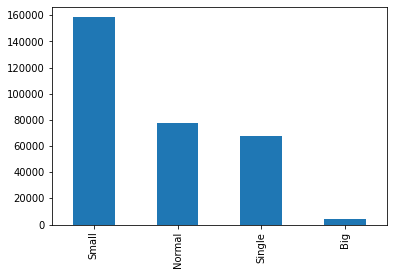

In [0]:
train['FAMILY SIZE'].value_counts().plot(kind='bar')

In [0]:
# bucketing children count
train['CNT_CHILDREN'].value_counts()

0.0     215371
1.0      61119
2.0      26749
3.0       3717
4.0        429
5.0         84
6.0         21
7.0          7
14.0         3
12.0         2
10.0         2
8.0          2
19.0         2
9.0          2
11.0         1
Name: CNT_CHILDREN, dtype: int64

In [0]:
bins = pd.IntervalIndex.from_tuples([(-1,0), (0,20)])
train['IS_CHILDREN'] = pd.cut(train['CNT_CHILDREN'],bins)
train['IS_CHILDREN']=train['IS_CHILDREN'].astype('str')

test['IS_CHILDREN'] = pd.cut(test['CNT_CHILDREN'],bins)
test['IS_CHILDREN']=test['IS_CHILDREN'].astype('str')

In [0]:
train['IS_CHILDREN']=train['IS_CHILDREN'].replace('(-1, 0]','0')
train['IS_CHILDREN']=train['IS_CHILDREN'].replace('(0, 20]','1')

test['IS_CHILDREN']=test['IS_CHILDREN'].replace('(-1, 0]','0')
test['IS_CHILDREN']=test['IS_CHILDREN'].replace('(0, 20]','1')

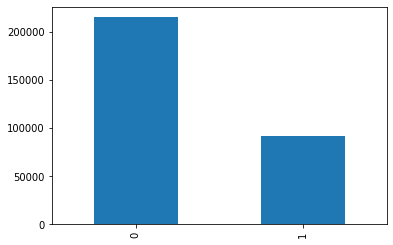

In [0]:
train['IS_CHILDREN'].value_counts().plot(kind='bar')

In [0]:
# credit income ratio
train['credit_income_ratio'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
test['credit_income_ratio'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']

In [0]:
# annuity income ratio
train['annuity_income_ratio'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
test['annuity_income_ratio'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']

In [0]:
train['FLAG_OWN_CAR']=train['FLAG_OWN_CAR'].replace('N',0)
train['FLAG_OWN_CAR']=train['FLAG_OWN_CAR'].replace('Y',1)

train['CODE_GENDER']=train['CODE_GENDER'].replace('F',0)
train['CODE_GENDER']=train['CODE_GENDER'].replace('M',1)

test['FLAG_OWN_CAR']=test['FLAG_OWN_CAR'].replace('N',0)
test['FLAG_OWN_CAR']=test['FLAG_OWN_CAR'].replace('Y',1)

test['CODE_GENDER']=test['CODE_GENDER'].replace('F',0)
test['CODE_GENDER']=test['CODE_GENDER'].replace('M',1)

In [0]:
train = train.loc[~(train['CODE_GENDER'] == 'XNA'), :]

In [0]:
train.drop(columns = ['DAYS_BIRTH','DAYS_EMPLOYED'], inplace = True)
test.drop(columns = ['DAYS_BIRTH','DAYS_EMPLOYED'], inplace = True)

In [0]:
train.shape, test.shape

((307507, 78), (48744, 77))

Save the processed files

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train.to_csv(r'/content/drive/My Drive/Projects/Home Credit Default Risk/train.csv', index=False)
test.to_csv(r'/content/drive/My Drive/Projects/Home Credit Default Risk/test.csv', index=False)